In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
pd.set_option('display.max_columns', None)

In [2]:
def parse_results(filename:str) -> pd.DataFrame:
    "Parse results text filename and creates a pandas DataFrame"
    
    data = defaultdict(list)
    with open(filename) as file:
        for line in file:
            if line == '\n':
                continue
            if line[:3] == 'mse':
                result = line.replace(" ", "").split(',')
                data['MSE'].append(round(float(result[0].split(':')[1]),8))
                data['MAE'].append(round(float(result[1].split(':')[1]),8))
                data['RMSE'].append(round(float(result[2].split(':')[1]),8))
                data['MAPE'].append(round(float(result[3].split(':')[1]),8))
                data['MSPE'].append(round(float(result[4].split(':')[1]),8))
                data['RSE'].append(round(float(result[5].split(':')[1]),8))
                data['R2'].append(round(float(result[6].split(':')[1]),8))
                data['train_time'].append(round(float(result[7].split(':')[1]),8))
                data['test_time'].append(round(float(result[8].split(':')[1]),8))
                if len(result) > 9:
                    data['epochs'].append(round(float(result[9].split(':')[1]),8))
                else:
                    data['epochs'].append(1)
                    
            else:
                attributes = line.split(sep='_')
#                 print(attributes[0])
                data['model'].append(attributes[0])
                data['lookback'].append(int(attributes[1].split('-')[1]))
                data['future'].append(int(attributes[3].split('-')[1]))
                data['pos'].append(attributes[5].split('-')[1])
                data['val'].append(attributes[6].split('-')[1])
                data['temp'].append(attributes[7].split('-')[1].split(' ')[0])

    return pd.DataFrame.from_dict(data)

def parse_lstms(filename:str) -> pd.DataFrame:
    "Parse results text filename and creates a pandas DataFrame"
    
    data = defaultdict(list)
    with open(filename) as file:
        for line in file:
            if line == '\n':
                continue
            if line[:3] == 'mse':
                result = line.replace(" ", "").split(',')
                data['MSE'].append(round(float(result[0].split(':')[1]),8))
                data['MAE'].append(round(float(result[1].split(':')[1]),8))
                data['RMSE'].append(round(float(result[2].split(':')[1]),8))
                data['MAPE'].append(round(float(result[3].split(':')[1]),8))
                data['R2'].append(round(float(result[4].split(':')[1]),8))
            else:
                attributes = line.split(sep='_')
                model = attributes[0]
                data['lookback'].append(int(attributes[2].split('-')[1]))
                data['future'].append(int(attributes[3].split('-')[1]))

    return pd.DataFrame.from_dict(data)

def slice_and_dice(formers:pd.DataFrame, lstms: pd.DataFrame) -> pd.DataFrame:
    """."""
    transformer, autoformer, informer = \
    formers[formers['model'] == 'Transformer'].drop('model', axis = 1), \
    formers[formers['model'] == 'Autoformer'].drop('model', axis = 1), \
    formers[formers['model'] == 'Informer'].drop('model', axis = 1),
    df = autoformer.merge(informer, how = "left", on=["lookback", "future", "pos", "val", "temp"], \
                              suffixes=('-Autoformer', '-Informer'))\
                       .merge(transformer, how = "left", on=["lookback", "future", "pos", "val", "temp"], \
                             suffixes=('_ello', '-Transformer'))\
                       .merge(lstms, how="left",  on=["lookback", "future"], suffixes=('-Transformer', '-LSTM'))

    return df

In [3]:
formers_org = parse_results('formers-original-data.txt').\
                drop_duplicates(subset=['model', 'lookback', 'future', 'pos','val','temp'])
formers_org['time_per_epoch'] = formers_org['train_time']/formers_org['epochs']
lstms_org = parse_lstms('result-lstm-original-data.txt')
lstms_red = parse_lstms('result-lstm-reduced-data.txt')

In [4]:
# formers_org.head(10)
# missing_df = formers_org.groupby(['model','lookback','future']).count()
# missing_df[missing_df['pos'] != 7]

In [5]:
df_org = slice_and_dice(formers_org, lstms_org)
df_org['data_type'] = 'original'
# df_red = slice_and_dice(formers_red, lstms_red)
# df_red['data_type'] = 'reduced'
# df_merged = pd.concat([df_org, df_red], ignore_index=True, sort=False)
# df_merged.info()

In [6]:
# df_merged.to_csv('results_new_format.csv',index=False)
# df_org.info()
# df_org[df_org['lookback']==144]

Text(0.5, 1.0, 'Time Per Epoch')

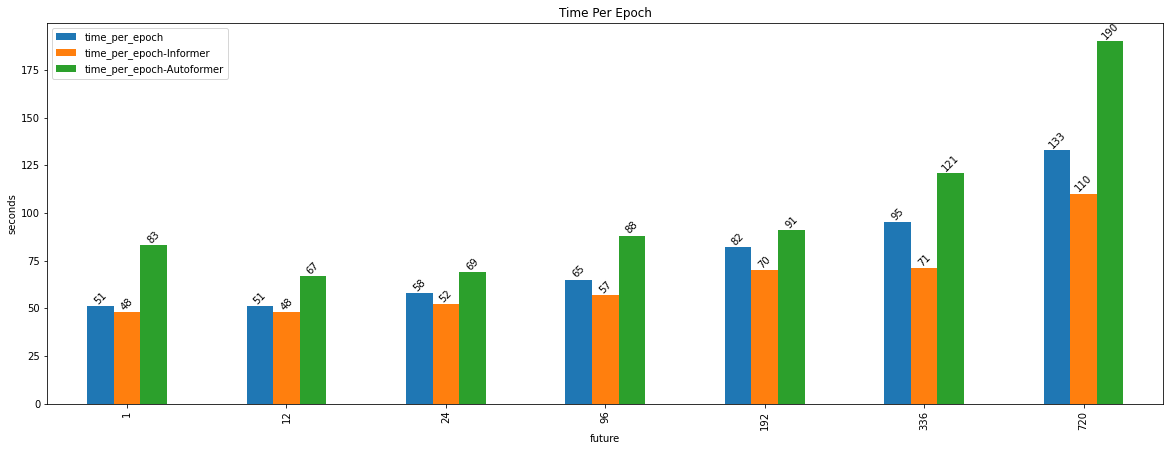

In [7]:
## time comparison ##

lookback = 336
columns = ['time_per_epoch','time_per_epoch-Informer','time_per_epoch-Autoformer']
# columns = ['test_time','test_time-Autoformer','test_time-Informer']
time_df = df_org[['lookback', 'future', 'pos', 'val', 'temp',\
                  'time_per_epoch-Autoformer','time_per_epoch-Informer','time_per_epoch',\
                  'test_time-Autoformer','test_time-Informer','test_time',\
                  'train_time-Autoformer','train_time-Informer','train_time',\
                  'epochs-Autoformer','epochs-Informer','epochs']]
time_df = time_df[time_df['epochs']>2]
time_inf = time_df[(time_df['lookback'] == lookback) & (time_df['pos'] == 'True')\
        & (time_df['val'] == 'True') & (time_df['temp'] == 'True')]\
        [['lookback', 'future', 'time_per_epoch-Informer','epochs-Informer','test_time-Informer']]
time_tra = time_df[(time_df['lookback'] == lookback) & (time_df['pos'] == 'True')\
        & (time_df['val'] == 'False') & (time_df['temp'] == 'False')]\
        [['lookback', 'future', 'time_per_epoch','epochs','test_time']]
time_aut = time_df[(time_df['lookback'] == lookback) & (time_df['pos'] == 'False')\
        & (time_df['val'] == 'True') & (time_df['temp'] == 'True')]\
        [['lookback', 'future', 'time_per_epoch-Autoformer','epochs-Autoformer','test_time-Autoformer']]
time_formers = time_inf.merge(time_tra, how = "left", on=["lookback", "future"],suffixes=('-Autoformer', '-Informer'))\
             .merge(time_aut, how = "left", on=["lookback", "future"],suffixes=('_ello', '-Transformer'))
# time_formers
time_formers = time_formers.round(0)
time_formers
ax = time_formers.plot.bar(x='future', y=columns, figsize=(20,7))
ax.set_ylabel('seconds')
ax.bar_label(ax.containers[0], rotation = 45)
ax.bar_label(ax.containers[1], rotation = 45)
ax.bar_label(ax.containers[2], rotation = 45)
# ax.legend(['Transformer','Informer','Autoformer'])
ax.set_title('Time Per Epoch')

In [9]:
def show_best_parameters_for_model(df, model = 'Transformer'):
    df = df.copy(deep=True)
    for lookback in [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]:
        for future in [1, 12, 24, 96, 192, 336, 720]:
            try:
                df_ = df[(df['lookback'] == lookback) & (df['future'] == future)]\
                      [['lookback','future','pos','val','temp','MAE-' + model]].reset_index(drop=True)
                res = df_.iloc[df_['MAE-' + model].idxmin()]
                print(list(res))
            except Exception as e:
                print('Lookback {} and future {} not found'.format(lookback, future))


# show_best_parameters_for_model(df_org, model = 'Autoformer')


In [9]:
# df_org[(df_org['lookback'] == 6) & (df_org['future'] == 1)][['lookback','future','pos','val','temp']]

In [17]:
def show_by_default_embeddings(df_, *args, x_axis = 'future', metric = 'mae'):
    """."""
    x_axis = x_axis
    df_ = df_.copy(deep=True)
    columns = list(args)
    
    if x_axis ==  'lookback':
        frame_by = 'future'
        loopby = [1, 12, 24, 96, 192, 336, 720]
    elif x_axis == 'future':
        frame_by = 'lookback'
        loopby = [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]
#         loopby = [6]
        

    for i in loopby:
        autoformer= df_org[(df_org[frame_by] == i) & (df_org['pos'] == 'False') & (df_org['temp'] == 'True')\
                    & (df_org['val'] == 'True')][['lookback','future',columns[2],columns[3]]]
        informer = df_org[(df_org[frame_by] == i) & (df_org['pos'] == 'True') & (df_org['temp'] == 'True')\
                     & (df_org['val'] == 'True')][['lookback','future',columns[1]]]
        transformer = df_org[(df_org[frame_by] == i) & (df_org['pos'] == 'True') & (df_org['temp'] == 'False')\
                     & (df_org['val'] == 'False')][['lookback','future',columns[0]]]
        df_merge = autoformer.merge(informer, how = "left", on=["lookback", "future"], suffixes=('_Auto', '_Inf'))\
                   .merge(transformer, how = "left", on=["lookback", "future"], suffixes=('_ello', '_Tra'))
        df_merge[columns] *= 10
        df_merge = df_merge.round(2)
#         print(df_merge.head())
        ax = df_merge.plot.bar(x=x_axis, y=columns, figsize=(20,7))
        for y in range(0, len(columns)):
            ax.bar_label(ax.containers[y], rotation = 45)
        ax.set_title(frame_by.upper() + " "+ str(i))

        

def show(df_, *args, x_axis = 'lookback', pos='True', val='False', temp='False'):
    """."""
    x_axis = x_axis
    df_ = df_.copy(deep=True)
    columns = list(args) 
#     df_[columns] *= 100
    df_ = df_.round(2)
    
    if x_axis ==  'lookback':
        frame_by = 'future'
        loopby = [1, 12, 24, 96, 192, 336, 720]
    elif x_axis == 'future':
        frame_by = 'lookback'
        loopby = [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]

    for i in loopby:
        ax = df_[(df_[frame_by] == i) & (df_['pos'] == pos) & (df_['temp'] == temp) 
               & (df_['val'] == val)]\
              .plot.bar(x=x_axis, y=columns, figsize=(15,5))
        for y in range(0, len(columns)):
            ax.bar_label(ax.containers[y], rotation = 45)
        ax.set_title(frame_by.upper() + " "+ str(i))

        
def show_embeddings_comb(df_, columns, lookback_list):
    df_ = df_.copy(deep=True)
#     df_[columns] *= 100
#     df_ = df_.round(2)
    

    for lookback in lookback_list:
        print(" "*40 + "============= LOOKBACK {} ==============".format(lookback))
        for pos in ["True", "False"]:
            for val in ["True", "False"]:
                for temp in ["True", "False"]:
                    if pos == "False" and val == "False" and temp == "False":
                        continue
                        
                    ax = df_[(df_['lookback'] == lookback) & \
                             (df_['pos'] == pos) & (df_['temp'] == temp) & (df_['val'] == val)]\
                         .plot.bar(x='future', y=columns, figsize=(15,5))
                    
                    for y in range(0, len(columns)):
                        ax.bar_label(ax.containers[y], rotation = 90)
                    
                    if pos == "False" and val == "True" and temp == "True":
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp + " ==> Default embeddings for AutoFormer")
                    elif pos == "True" and val == "True" and temp == "True":
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp + " ==> Default embeddings for InFormer")
                    else:
                        ax.set_title("pos " + pos + ", Val " + val + ", Temp " + temp) 
                    plt.show()



                                        ============= LOOKBACK 96 ==============


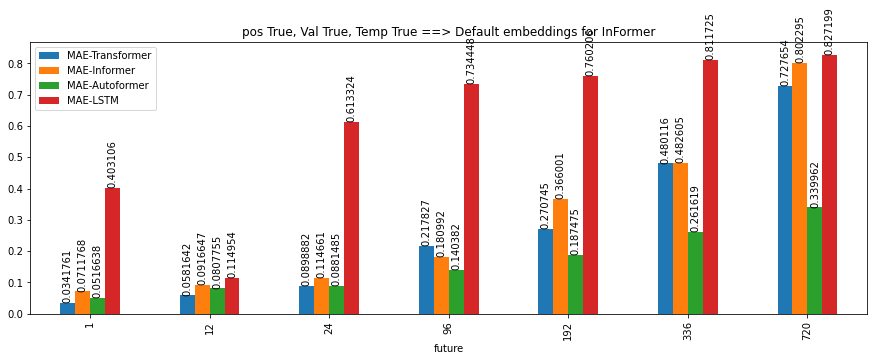

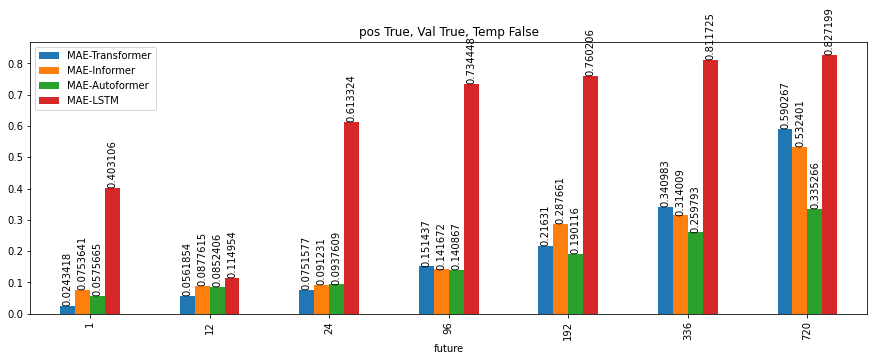

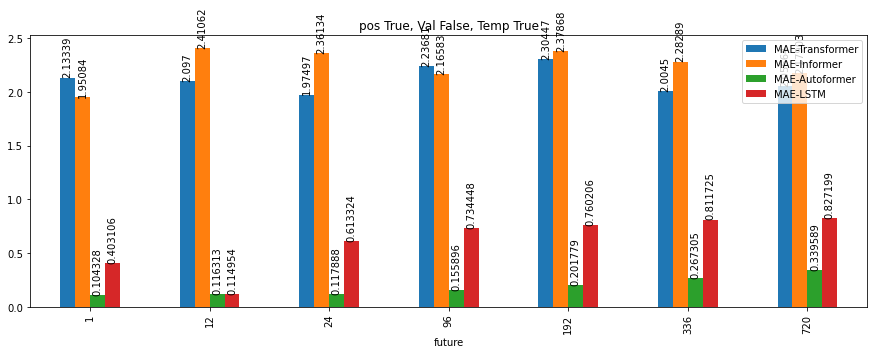

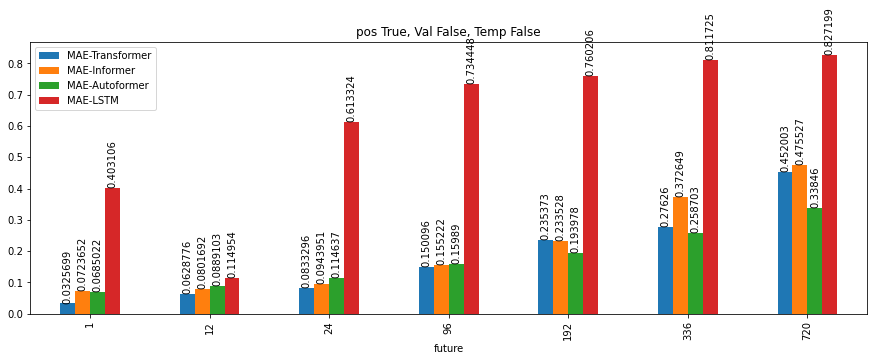

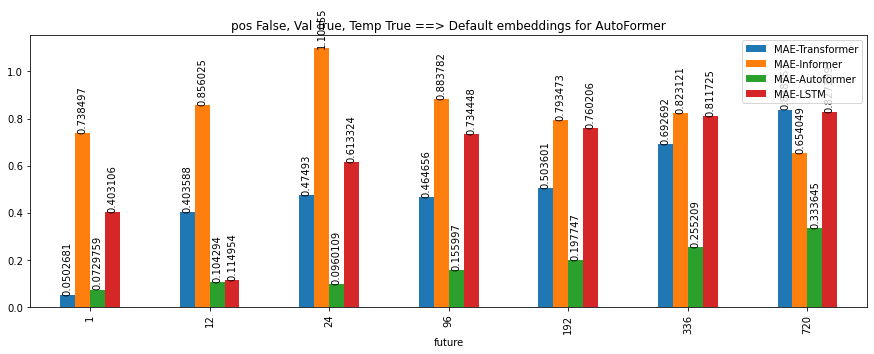

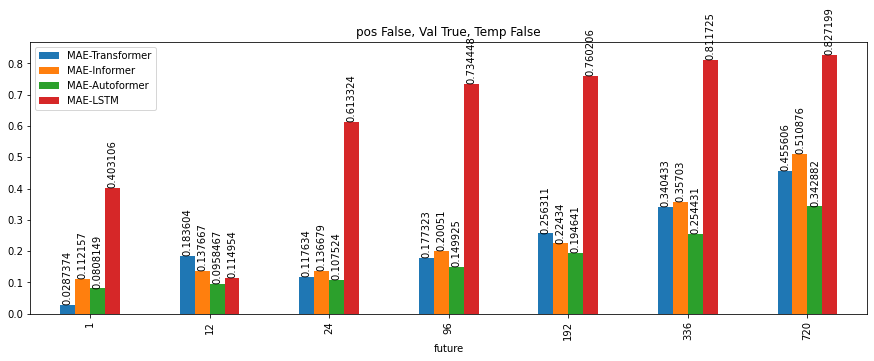

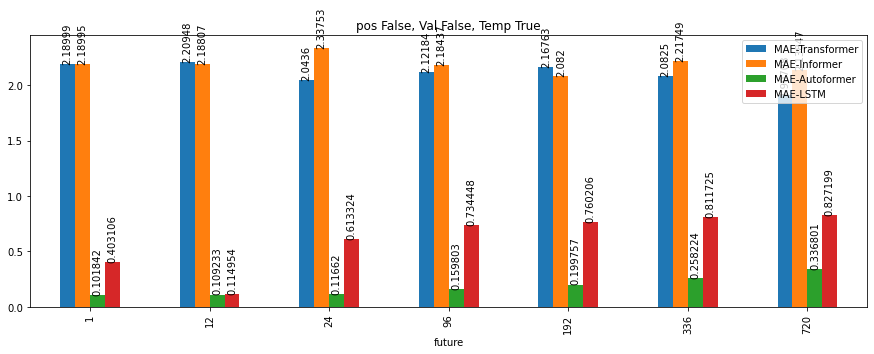

                                        ============= LOOKBACK 120 ==============


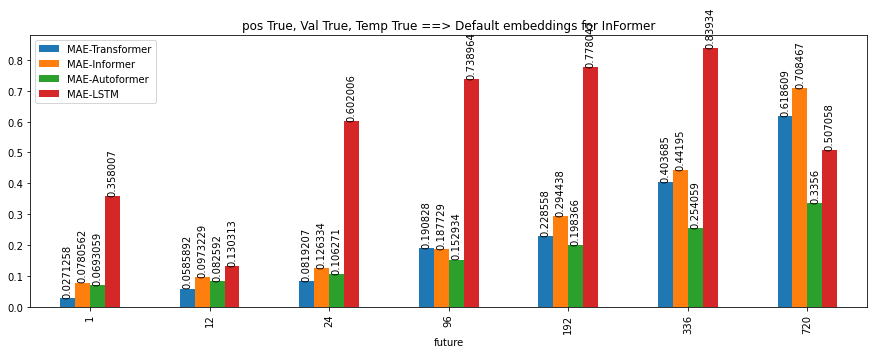

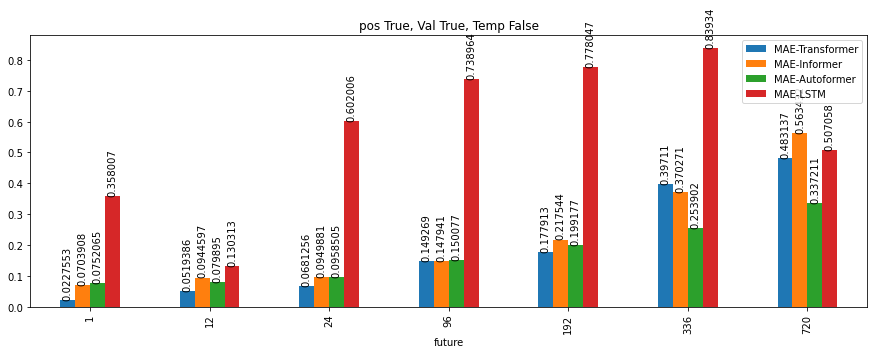

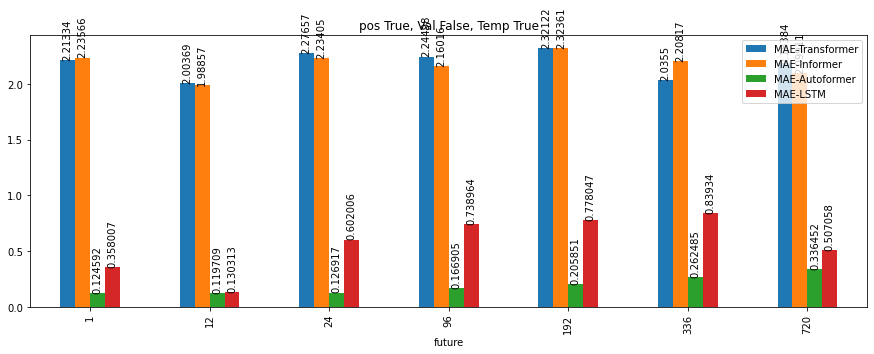

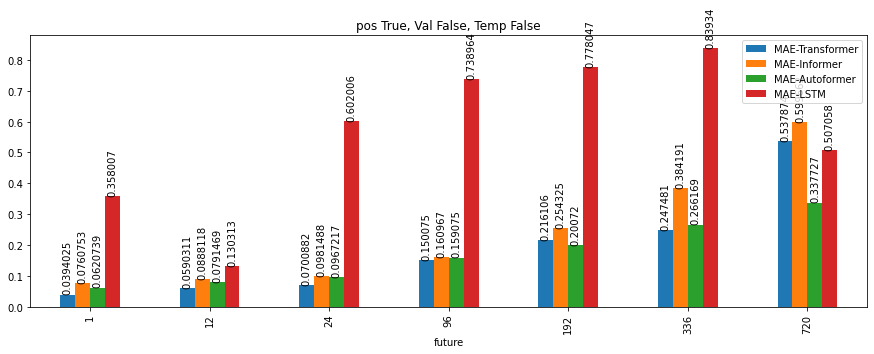

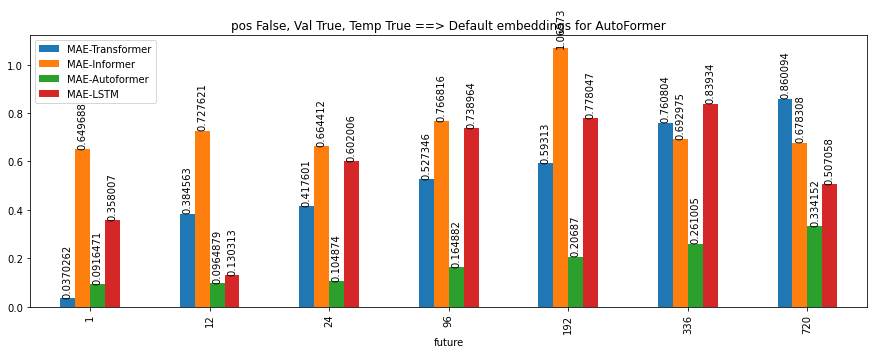

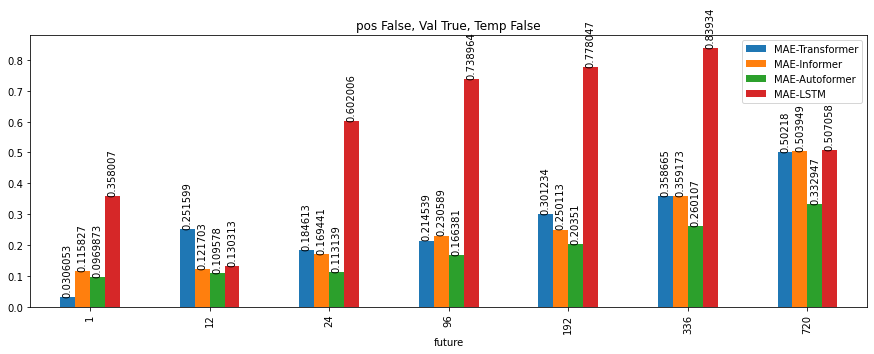

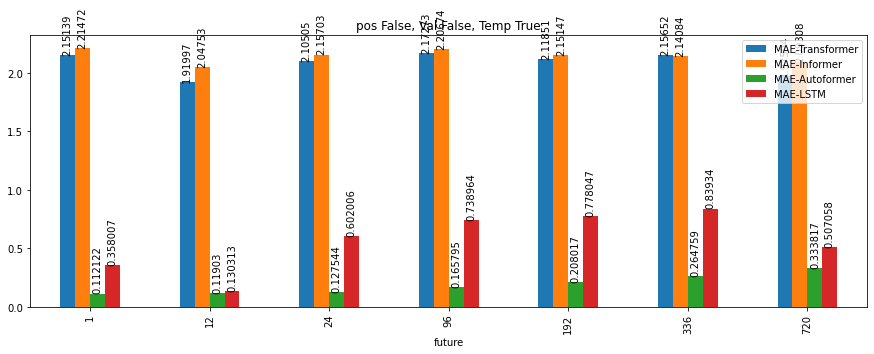

In [18]:
pos, val, temp = 'True', 'False', 'True'
metric = 'MAE'
columns = list(map(lambda x: metric + x, ['-Transformer','-Informer', '-Autoformer', '-LSTM']))
# show_by_default_embeddings(df_org, *columns, x_axis='future', metric=metric)
# show(df_org, *columns, x_axis='future', pos = pos, val = val, temp = temp) 
# for lookback in [6, 12, 24, 48, 72, 96, 120, 144, 168, 192, 336, 504, 672,720]:
show_embeddings_comb(df_org, columns, [96, 120])

In [101]:
# df_org[(df_org['mae_LSTM'] < df_org['mae_Tra']) \
#        & (df_org['mae_LSTM'] < df_org['mae_Auto']) \
#        & (df_org['mae_LSTM'] < df_org['mae_Inf'])].\
#         sort_values(['lookback','future'])\
#      [['lookback', 'future', 'pos', 'val', 'temp','mae_Tra','mae_Auto','mae_Inf','mae_LSTM']]

,lookback,future,pos,val,temp,mae_Tra,mae_Auto,mae_Inf,mae_LSTM
86,24,1,True,False,True,2.272295,0.849368,2.304019,0.378729
134,48,12,True,False,True,2.237099,0.082075,2.225618,0.071303
135,48,12,False,True,True,0.431867,0.073072,0.524129,0.071303
137,48,12,False,False,True,2.266790,0.081378,2.152783,0.071303
176,72,12,True,False,True,2.358007,0.104996,2.154376,0.066654
177,72,12,False,True,True,0.385312,0.090368,0.819165,0.066654
178,72,12,False,True,False,0.118522,0.081602,0.106960,0.066654
179,72,12,False,False,True,2.218353,0.096836,2.173762,0.066654
218,96,12,True,False,True,2.097003,0.116313,2.410616,0.114954
302,144,12,True,False,True,2.243661,0.128908,2.220154,0.065448
